In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import sys

from Bio import SeqIO
from datetime import datetime

from torch.utils import data
from data_generator import data_generator
from data_generator import Dataset
from lstm import LSTM_model

#from google.colab import drive

In [2]:
filename = "100k_rows.fasta"
dataset = Dataset(filename, 2000)
batch_size = 32
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

print(dataset.__getitem__(0)[0].size())
print(dataset.__getitem__(0)[1].size())

torch.Size([2000, 21])
torch.Size([21])


In [3]:
acids = "ACDEFGHIKLMNOPQRSTUVWY-"
loss_list = []
large_file = "uniref50.fasta"
small_file = "100k_rows.fasta"

max_seq_len = 2000

# Good sizes: 16/700 or 32/400 on laptop
# 32/1500 on desktop
batch_size = 32
hidden_dim = 1500

hidden_layers = 1

# Use Cuda if available
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

model = LSTM_model(len(acids), hidden_dim, hidden_layers, max_seq_len).to(processor)
#model = test_LSTM(len(acids), hidden_dim, hidden_layers).to(processor)
loss_function = nn.CrossEntropyLoss().to(processor)
#loss_function = nn.NLLLoss().to(processor)
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

dataset = Dataset(small_file, max_seq_len, acids=acids)
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)
print(dataset.__len__())

Using GPU: True
98341


In [4]:
#batches = dataset.__len__()
batches = 150
time_diff = 0
no_improv = 0
min_loss = float("inf")

for i, (batch, labels) in enumerate(base_generator):
    start_time = datetime.now()

    sys.stdout.write("\rEpoch: {0}. Min loss: {1:.5f}. Estimated time left: {2}. batches since improvement: {3}.".format(i+1, min_loss, time_diff*(batches - i), no_improv))
    
    model.zero_grad()

    batch = batch.to(processor)
    labels = labels.to(processor)

    output, (hn, cn) = model(batch)
    #print("Output size:", output.size())
    #print("labels size:", labels.size())
    loss = loss_function(output, labels)
    loss_list.append(loss)
    loss.backward()
    optimiser.step()

    if (loss.item() < min_loss):
        no_improv= 0
        min_loss = loss.item()
        checkpoint = {'model': model,
                      'state_dict': model.state_dict(),
                      'optimiser' : optimiser,
                      'optim_state' : optimiser.state_dict()}
    else:
        no_improv += 1
        #torch.save(checkpoint, 'checkpoint.pth')

    end_time = datetime.now()
    time_diff = end_time - start_time

    if i+1 >= batches:
        break

Epoch: 150. Min loss: 0.02729. Estimated time left: 0:00:00.901001. batches since improvement: 0.

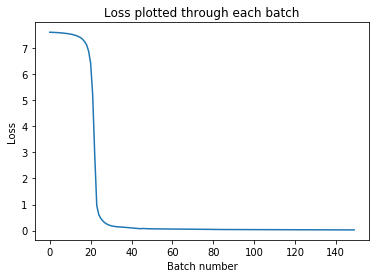

In [5]:
# Plotting the loss through the epochs
plt.plot(loss_list)
#plt.scatter(range(len(loss_list)), loss_list)
plt.title("Loss plotted through each batch")
plt.ylabel("Loss")
plt.xlabel("Batch number")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("loss_log.png")

In [6]:

# Haven't touched this yet. None of it will work
print(data_gen.data.shape)
seqs = data_gen.data.view(max_seq_len,batch_size,21)
seqs = seqs.type(torch.float)
print(type(seqs))
seqs = seqs.to(device='cuda')
test = LSTM_model(21,500,1)
model.zero_grad()


test_data = test.forward(seqs)


#output = test.forward(char_seqs)
#output = output.detach().numpy()
#argmax = np.argmax(output[0])
#print(argmax)
#print(output[0][argmax])

NameError: name 'data_gen' is not defined